In [18]:
from typing import Tuple, List
from intern import array
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


# Custom BossDB Dataset classes for Pytorch DataLoaders

In this notebook we provide some example custom Dataset classes for use with Pytorch DataLoaders. Please see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html  and https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for additional information. These classes can easily be adapted for your specific needs.


### Common Definitions:

**boss_uri**: the BossDB path to the project, channel, and experiment you would like to use, e.g. `'bossdb://kuan_phelps2020/drosophila_brain_120nm/drBrain_120nm_rec'`

**boss_config**: if you are accessing a private dataset you can pass your boss config information (see https://github.com/jhuapl-boss/intern/wiki/Boss-Setup-Tutorial) however if you are accessing a public dataset you do not need a config and can leave the default `None` input

**centroid_list_zyx**: A list of coordinate points you would like the images/volumes/arrays to be centered on

**px_radius_*** : A list of the number of pixels on either side of the centroid (i.e. the radius) you would like to include in the image/volume/array. e.g. if I wanted each image to be 128x128 pixels I would set this to `[64, 64]`

**transform**: The transform or group of transforms you want to apply to the data. (see https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html)

### Dataset class for when you need single image slices from the data 

In [19]:
class BossDBSliceDataset(Dataset):
    """
    A dataset class for fetching single image slices from BossDB.
    
    Attributes:
        config (dict): Configuration dictionary for BossDB.
        array (array): Array object for the image data in BossDB.
        centroid_list (List[Tuple[int, int, int]]): List of centroids around which data slices will be fetched.
        px_radius_y (int): Pixel radius in the y dimension.
        px_radius_x (int): Pixel radius in the x dimension.
        transform (callable, optional): Transformations to be applied to the image data.
    
    Args:
        boss_uri (str): URI for the image data in BossDB.
        centroid_list_zyx (List[Tuple[int, int, int]]): List of centroids.
        px_radius_yx (Tuple[int, int]): Tuple representing the pixel radius in the (y, x) dimensions.
        boss_config (dict, optional): Configuration for BossDB. Defaults to None.
        transform (callable, optional): Transformations for the image data. Defaults to ToTensor().
    """
    
    def __init__(
        self, 
        boss_uri: str, 
        centroid_list_zyx: List[Tuple[int, int, int]],
        px_radius_yx: Tuple[int, int],
        boss_config: dict = None, 
        transform=ToTensor()
        
    ):
        self.config = boss_config
        self.array = array(boss_uri, boss_config=boss_config)
        self.centroid_list = centroid_list_zyx
        rad_y, rad_x = px_radius_yx
        self.px_radius_y = rad_y
        self.px_radius_x = rad_x
        self.transform = transform
    
    def __getitem__(self, key):
        """
        Fetches the image slice based on the given key (index).
        
        Args:
            key (int): Index for which the image slice is to be fetched.
        
        Returns:
            torch.Tensor: The fetched image slice.
        """
        z, y, x = self.centroid_list[key]
        array =  self.array[
            z : z + 1,
            y - self.px_radius_y : y + self.px_radius_y,
            x - self.px_radius_x : x + self.px_radius_x,
        ]
        if self.transform:
            array = self.transform(array)
            
        return array

    def __len__(self):
        """
        Returns the total number of centroids.
        
        Returns:
            int: Total number of image slices that can be fetched.
        """
        return len(self.centroid_list)

### Dataset class for when you need single image slices and corresponding segmentation masks from the data 

In [20]:
class BossDBSliceDataset(Dataset):
    """
    A dataset class for fetching single image slices and their corresponding segmentation masks from BossDB.
    
    Attributes:
        config (dict): Configuration dictionary for BossDB.
        image_array (array): Array object for the image data in BossDB.
        mask_array (array): Array object for the mask data in BossDB.
        centroid_list (List[Tuple[int, int, int]]): List of centroids around which data slices will be fetched.
        px_radius_y (int): Pixel radius in the y dimension.
        px_radius_x (int): Pixel radius in the x dimension.
        image_transform (callable, optional): Transformations to be applied to the image data.
        mask_transform (callable, optional): Transformations to be applied to the mask data.
    
    Args:
        image_boss_uri (str): URI for the image data in BossDB.
        mask_boss_uri (str): URI for the mask data in BossDB.
        boss_config (dict): Configuration for BossDB.
        centroid_list_zyx (List[Tuple[int, int, int]]): List of centroids.
        px_radius_yx (Tuple[int, int]): Tuple representing the pixel radius in the (y, x) dimensions.
        image_transform (callable, optional): Transformations for the image data. Defaults to ToTensor().
        mask_transform (callable, optional): Transformations for the mask data. Defaults to None.
    """
    
    def __init__(
        self, 
        image_boss_uri: str, 
        mask_boss_uri: str, 
        boss_config: dict, 
        centroid_list_zyx: List[Tuple[int, int, int]],
        px_radius_yx: Tuple[int, int],
        image_transform=ToTensor(),
        mask_transform=None
    ):
        self.config = boss_config
        self.image_array = array(image_boss_uri, boss_config=boss_config)
        self.mask_array = array(mask_boss_uri, boss_config=boss_config)
        self.centroid_list = centroid_list_zyx
        rad_y, rad_x = px_radius_yx
        self.px_radius_y = rad_y
        self.px_radius_x = rad_x
        self.image_transform = image_transform
        self.mask_transform = mask_transform
    
    def __getitem__(self, key):
        """
        Fetches the image slice and its corresponding mask based on the given key (index).
        
        Args:
            key (int): Index for which the image slice and mask are to be fetched.
        
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The fetched image slice and its corresponding mask.
        """
        z, y, x = self.centroid_list[key]
        image_array =  self.image_array[
            z : z + 1,
            y - self.px_radius_y : y + self.px_radius_y,
            x - self.px_radius_x : x + self.px_radius_x,
        ]
        mask_array =  self.mask_array[
            z : z + 1,
            y - self.px_radius_y : y + self.px_radius_y,
            x - self.px_radius_x : x + self.px_radius_x,
        ]
        
        
        if self.image_transform:
            image_array= self.image_transform(image_array)
            
        if self.mask_transform:
            mask_array = self.mask_transform(mask_array)
        
        mask_array = torch.from_numpy(mask_array.astype('int64')).long()
            
        return image_array, mask_array

    def __len__(self):
        """
        Returns the total number of centroids.
        
        Returns:
            int: Total number of image slices and masks that can be fetched.
        """
        return len(self.centroid_list)

### Dataset class for when you need 3D image volumes from the data 

In [21]:
class BossDBDataset(Dataset):
    """
    A dataset class for fetching 3D image volumes from BossDB.

    Attributes:
        config (dict): Configuration dictionary for BossDB.
        array (array): Array object for the data in BossDB.
        centroid_list (List[Tuple[int, int, int]]): List of centroids around which data slices will be fetched.
        px_radius_z (int): Pixel radius in the z dimension.
        px_radius_y (int): Pixel radius in the y dimension.
        px_radius_x (int): Pixel radius in the x dimension.
        transform (callable, optional): Transformations to be applied to the data.

    Args:
        boss_uri (str): URI for the data in BossDB.
        centroid_list_zyx (List[Tuple[int, int, int]]): List of centroids.
        px_radius_zyx (Tuple[int, int, int]): Tuple representing the pixel radius in the (z, y, x) dimensions.
        transform (callable, optional): Transformations for the data. Defaults to ToTensor().
        boss_config (dict, optional): Configuration for BossDB. Defaults to None.
    """
    
    def __init__(
        self, 
        boss_uri: str, 
        centroid_list_zyx: List[Tuple[int, int, int]],
        px_radius_zyx: Tuple[int, int, int],
        transform=ToTensor(),
        boss_config: dict = None, 
    ):
        self.config = boss_config
        self.array = array(boss_uri, boss_config=boss_config)
        self.centroid_list = centroid_list_zyx
        rad_z, rad_y, rad_x = px_radius_zyx
        self.px_radius_z = rad_z
        self.px_radius_y = rad_y
        self.px_radius_x = rad_x
        self.transform = transform
    
    def __getitem__(self, key):
        """
        Fetches the data slice based on the given key (index).
        
        Args:
            key (int): Index for which the data slice is to be fetched.
        
        Returns:
            torch.Tensor: The fetched data slice.
        """
        z, y, x = self.centroid_list[key]
        array = self.array[
            z - self.px_radius_z : z + self.px_radius_z,
            y - self.px_radius_y : y + self.px_radius_y,
            x - self.px_radius_x : x + self.px_radius_x,
        ]
        if self.transform:
            array = self.transform(array)
            
        return array

    def __len__(self):
        """
        Returns the total number of centroids.
        
        Returns:
            int: Total number of data slices that can be fetched.
        """
        return len(self.centroid_list)
    

# Tutorial - example walkthrough with 3D image volumes and segmentations masks

### Dataset class for when you need 3D image volumes and corresponding segmentation masks from the data 

In [22]:
class BossDBDataset(Dataset):
    """
    A dataset class for fetching 3D image volumes and their corresponding segmentation masks from BossDB.
    
    Attributes:
        config (dict): Configuration dictionary for BossDB.
        image_array (array): Array object for the image data in BossDB.
        mask_array (array): Array object for the mask data in BossDB.
        centroid_list (List[Tuple[int, int, int]]): List of centroids around which data slices will be fetched.
        px_radius_z (int): Pixel radius in the z dimension.
        px_radius_y (int): Pixel radius in the y dimension.
        px_radius_x (int): Pixel radius in the x dimension.
        image_transform (callable, optional): Transformations to be applied to the image data.
        mask_transform (callable, optional): Transformations to be applied to the mask data.
    
    Args:
        image_boss_uri (str): URI for the image data in BossDB.
        mask_boss_uri (str): URI for the mask data in BossDB.
        centroid_list_zyx (List[Tuple[int, int, int]]): List of centroids.
        px_radius_zyx (Tuple[int, int, int]): Tuple representing the pixel radius in the (z, y, x) dimensions.
        image_transform (callable, optional): Transformations for the image data. Defaults to ToTensor().
        mask_transform (callable, optional): Transformations for the mask data. Defaults to None.
        boss_config (dict, optional): Configuration for BossDB. Defaults to None.
    """
    
    def __init__(
        self, 
        image_boss_uri: str, 
        mask_boss_uri: str, 
        centroid_list_zyx: List[Tuple[int, int, int]],
        px_radius_zyx: Tuple[int, int, int],
        image_transform=ToTensor(),
        mask_transform=None,
        boss_config: dict = None, 
    ):
        self.config = boss_config
        self.image_array = array(image_boss_uri, boss_config=boss_config)
        self.mask_array = array(mask_boss_uri, boss_config=boss_config)
        self.centroid_list = centroid_list_zyx
        rad_z, rad_y, rad_x = px_radius_zyx
        self.px_radius_z = rad_z
        self.px_radius_y = rad_y
        self.px_radius_x = rad_x
        self.image_transform = image_transform
        self.mask_transform = mask_transform
    
    def __getitem__(self, key):
        """
        Fetches the image and mask data based on the given key (index).
        
        Args:
            key (int): Index for which the data slice is to be fetched.
        
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The fetched image and mask data slice.
        """
        z, y, x = self.centroid_list[key]
        image_array = self.image_array[
            z - self.px_radius_z : z + self.px_radius_z,
            y - self.px_radius_y : y + self.px_radius_y,
            x - self.px_radius_x : x + self.px_radius_x,
        ]
        
        mask_array = self.mask_array[
            z - self.px_radius_z : z + self.px_radius_z,
            y - self.px_radius_y : y + self.px_radius_y,
            x - self.px_radius_x : x + self.px_radius_x,
        ]
        if self.image_transform:
            image_array = self.image_transform(image_array)  # Corrected this line
            
        if self.mask_transform:
            mask_array = self.mask_transform(mask_array)
        
        mask_array = torch.from_numpy(mask_array.astype('int64')).long()
            
        return image_array, mask_array

    def __len__(self):
        """
        Returns the total number of centroids.
        
        Returns:
            int: Total number of data slices that can be fetched.
        """
        return len(self.centroid_list)

## 1. Setting up the BossDB URIs

For this demonstration, we'll use the [Kasthuri dataset](https://bossdb.org/project/kasthuri2015) from BossDB. We'll define URIs for both the membrane and synapse tasks.

### Specifying Image Channels and Slices from the Kasthuri Dataset

When working with electron microscopy (EM) data, especially from datasets like the Kasthuri dataset, it's crucial to specify which channels of the data you're interested in. The Kasthuri dataset, for instance, contains multiple channels representing different structures and annotations.

### Electron Microscopy (EM) Data Channel

For our purposes, we'll be pulling data from the main EM channel. This channel provides grayscale images that represent the electron density at each voxel in the dataset. These images are crucial for understanding the underlying structures in the tissue.

In [23]:
# Define the BossDB URIs for the Kasthuri dataset
image_boss_uri = "bossdb://Kasthuri/ac4/em"

### Annotation Channels

In addition to the main EM data, the Kasthuri dataset provides several annotation channels. Each channel represents a different kind of annotation, such as cell boundaries, synapses, or other structures. For this tutorial:

- **Membrane Annotation:** We'll use the membrane annotation channel. This channel provides binary masks where the cell boundaries (or membranes) are labeled.
- **Synapse Annotation:** We'll also use the synapse annotation channel. This channel provides binary masks where the synapses are labeled.

In [24]:
# Annotation Channels
mask_boss_uri_membrane = "bossdb://Kasthuri/ac4/membrane"
mask_boss_uri_synapse = "bossdb://Kasthuri/ac4/synapse"

## 2. Defining Centroids and Pixel Radii

We need to specify the centroids around which the data slices will be fetched. Additionally, we'll define the pixel radius to determine the size of the fetched data slice.


In [25]:
# Define the centroid list and pixel radius
centroid_list_zyx = [(50, 256, 256), (60, 256, 256), (70, 256, 256)]  # Example centroids
px_radius_zyx = (0.5, 128, 128)  # Example pixel radius


## 3. Creating the Datasets

Using the defined URIs, centroids, and pixel radii, we can now create datasets for both the membrane and synapse tasks.


In [26]:
# Create the datasets
membrane_dataset = BossDBDataset(image_boss_uri, mask_boss_uri_membrane, centroid_list_zyx, px_radius_zyx)
synapse_dataset = BossDBDataset(image_boss_uri, mask_boss_uri_synapse, centroid_list_zyx, px_radius_zyx)

/Users/latchtd1/Documents/bossdb_cookbook/.venv/lib/python3.11/site-packages/intern/convenience/array.py:922: ImportWarning: CloudVolume is not installed. Accessing channel using CVDB.
  warnings.warn(


## 4. Fetching and Visualizing Data

With the datasets created, we can fetch specific slices of data and visualize them. For this demonstration, we'll fetch a sample from the membrane dataset.

In [27]:
# Fetch a sample from the membrane dataset
image, mask = membrane_dataset[0]

# Similarly, you can fetch samples from the synapse dataset

## 5. Visualizing Image and Mask

After fetching the data slices, it's essential to visualize them to ensure the correctness of the fetched data and to gain insights. We'll use the `visualize_image_mask` function to display the image and its corresponding mask side by side.

### Function Definition

The `visualize_image_mask` function takes in two arguments: the image tensor and the mask tensor. It then visualizes them side by side using matplotlib.

### Function Description

The `visualize_image_mask` function is designed to provide a quick and easy way to visualize the image and its corresponding mask. Here's a breakdown of its functionality:

- **Input Tensors:** The function accepts two tensors - the image and the mask. Both tensors are expected to be 2D (height x width) or 3D (channels x height x width). If a channel dimension exists and is of size 1, it gets squeezed out for visualization.
- **Visualization:** The function uses matplotlib to display the image and mask side by side. The image is displayed using a grayscale colormap.
- **Layout:** The visualizations are displayed without axis ticks for clarity, and the titles "Image" and "Mask" are used to label the respective visualizations.

In [28]:
def visualize_image_mask(image, mask, slice_idx=None):
    """
    Visualize the image and mask side by side.
    
    Args:
        image (torch.Tensor): The image tensor.
        mask (torch.Tensor): The mask tensor.
        slice_idx (int, optional): The index of the slice to visualize. If None, the middle slice is used.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # If the image has a channel dimension, remove it
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image.squeeze(0)
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)
    
    # If the data is 3D, select a slice
    if len(image.shape) == 3:
        if slice_idx is None:
            slice_idx = image.shape[1] // 2  # Use the middle slice if not specified
        image = image[:, slice_idx, :]
        mask = mask[slice_idx, :, :]
    
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Image')
    ax1.axis('off')
    
    ax2.imshow(mask)
    ax2.set_title('Mask')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


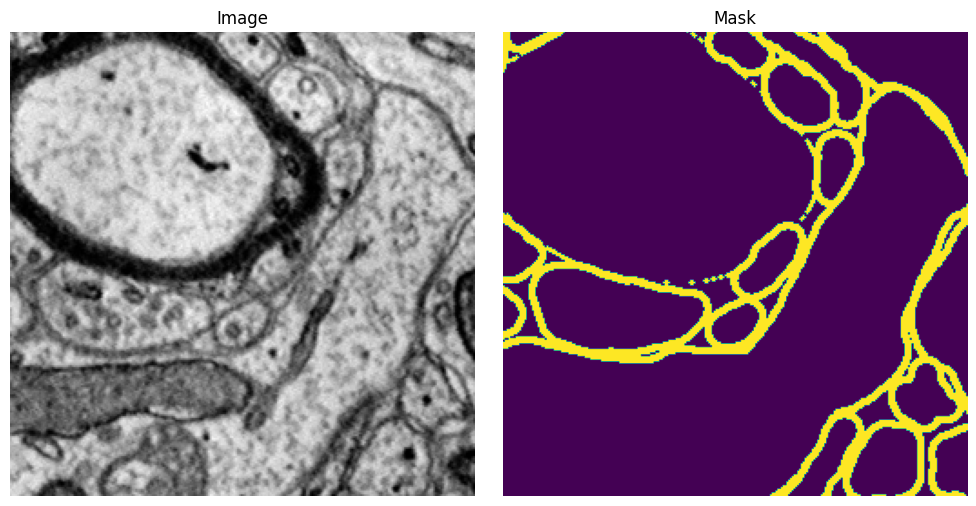

In [29]:
# Visualize the image and mask
visualize_image_mask(image, mask)

In [30]:
#Data Characteristics
print(f'Shape of input: {image.shape}')
print(f'Shape of groundtruth annotations: {mask.shape}')

Shape of input: torch.Size([1, 256, 256])
Shape of groundtruth annotations: torch.Size([256, 256])


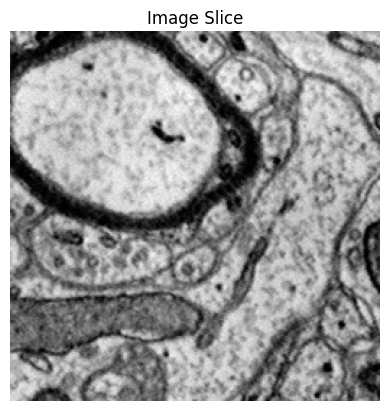

In [31]:
# Select the first slice along the depth
slice_image = image[0, : :]

# Display the slice
plt.imshow(slice_image, cmap='gray')
plt.title('Image Slice')
plt.axis('off')  # To hide axis values
plt.show()


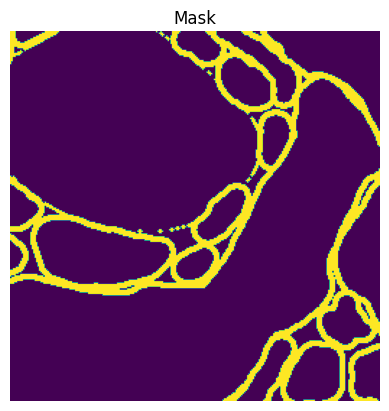

In [32]:
# Convert the mask tensor back to numpy for visualization
mask_numpy = mask.numpy()

# Display the first slice (z=0) of the mask
plt.imshow(mask_numpy[:, ])
plt.title('Mask')
plt.axis('off')  # To hide axis values
plt.show()